# Pre-employment coursework
## Exercise 2 - DenseNet-BC Autoencoder

- **Author:** Jan Xu
- **Model:** An encoder-decoder network with bottleneck dense blocks.
- **Aim:** Model should be trained such that its output is a reconstruction of the input.
- **Sources:** Huang et al. (2016), *Densely Connected Convolutional Networks*, https://arxiv.org/pdf/1608.06993.pdf

## Import packages and modules

In [1]:
# Imports
from collections import OrderedDict

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

import torchvision
from torchvision.transforms import transforms

from utils import *

print(torch.__version__)
print(torchvision.__version__)

1.3.0
0.4.1


## Load the CIFAR-10 dataset

In [2]:
# Define transform
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

CIFAR_set = torchvision.datasets.CIFAR10(root='../data/CIFAR10', train=True,
                                         download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='../data/CIFAR10', train=False,
                                        download=True, transform=transform)

train_set, val_set = train_val_split(CIFAR_set, 0.1)

Files already downloaded and verified
Files already downloaded and verified


## Define model

In [3]:
class DenseLayer(nn.Module):
    """
    A dense layer, consisting of two convolutional filters with batch
    normalisation and ReLU activation functions. The input layer is
    concatenated with the output layer.
    """
    
    def __init__(self, in_channels, growth_rate, mode='encode'):
        assert mode in ['encode', 'decode'], "Mode must be either 'encode' or 'decode'."
        super(DenseLayer, self).__init__()
        self.BN1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        if mode == 'encode':
            self.conv1 = nn.Conv2d(in_channels, 4*growth_rate, 1, 1, 0)
            self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, 3, 1, 1)
        elif mode == 'decode':
            self.conv1 = nn.ConvTranspose2d(in_channels, 4*growth_rate, 1, 1, 0)
            self.conv2 = nn.ConvTranspose2d(4*growth_rate, growth_rate, 3, 1, 1)
        self.BN2 = nn.BatchNorm2d(4*growth_rate)
        self.relu2 = nn.ReLU()
    
    def forward(self, x):
        bn1 = self.BN1(x)
        relu1 = self.relu1(bn1)
        conv1 = self.conv1(relu1)
        bn2 = self.BN2(conv1)
        relu2 = self.relu2(bn2)
        conv2 = self.conv2(relu2)
        return torch.cat([x, conv2], dim=1)

In [4]:
class DenseBlock(nn.Module):
    """
    A dense block, consisting of three dense layers.
    """
    
    def __init__(self, in_channels, growth_rate, mode='encode'):
        assert mode in ['encode', 'decode'], "Mode must be either 'encode' or 'decode'."
        super(DenseBlock, self).__init__()
        self.DL1 = DenseLayer(in_channels+(growth_rate*0), growth_rate, mode)
        self.DL2 = DenseLayer(in_channels+(growth_rate*1), growth_rate, mode)
        self.DL3 = DenseLayer(in_channels+(growth_rate*2), growth_rate, mode)
    
    def forward(self, x):
        DL1 = self.DL1(x)
        DL2 = self.DL2(DL1)
        DL3 = self.DL3(DL2)
        return DL3

class TransitionBlock(nn.Module):
    """
    A transition block, consisting of a convolutional layer followed by a
    resize layer (average pooling for downsampling, transpose convolutional
    layer for upsampling).
    """
    
    def __init__(self, in_channels, c_rate, mode='encode'):
        assert mode in ['encode', 'decode'], "Mode must be either 'encode' or 'decode'."
        super(TransitionBlock, self).__init__()
        out_channels = int(c_rate*in_channels)
        self.BN = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        if mode == 'encode':
            self.conv = nn.Conv2d(in_channels, out_channels, 1, 1, 0)
            self.resize_layer = nn.AvgPool2d(2, 2)
        elif mode == 'decode':
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, 1, 1, 0)
            self.resize_layer = nn.ConvTranspose2d(out_channels, out_channels, 2, 2, 0)
    
    def forward(self, x):
        bn = self.BN(x)
        relu = self.relu(bn)
        conv = self.conv(relu)
        output = self.resize_layer(conv)
        return output

In [5]:
class Encoder(nn.Module):
    """
    Encoder class, mainly consisting of three dense blocks and two
    transition blocks.
    """
    
    def __init__(self):
        super(Encoder, self).__init__()
        self.init_conv = nn.Conv2d(3, 24, 3, 2, 1) # 24 16 16
        self.BN1 = nn.BatchNorm2d(24)
        self.relu1 = nn.ReLU()
        self.db1 = DenseBlock(24, 8, 'encode') # 48 16 16
        self.tb1 = TransitionBlock(48, 0.5, 'encode') # 24 8 8
        self.db2 = DenseBlock(24, 8, 'encode') # 48 8 8
        self.tb2 = TransitionBlock(48, 0.5, 'encode') # 24 4 4
        self.db3 = DenseBlock(24, 8, 'encode') # 48 4 4
        self.BN2 = nn.BatchNorm2d(48)
        self.relu2 = nn.ReLU()
        self.down_conv = nn.Conv2d(48, 24, 2, 2, 0) # 24 2 2
    
    def forward(self, inputs):
        init_conv = self.init_conv(inputs)
        bn1 = self.BN1(init_conv)
        relu1 = self.relu1(bn1)
        db1 = self.db1(relu1)
        tb1 = self.tb1(db1)
        db2 = self.db2(tb1)
        tb2 = self.tb2(db2)
        db3 = self.db3(tb2)
        bn2 = self.BN2(db3)
        relu2 = self.relu2(bn2)
        down_conv = self.down_conv(relu2)
        return down_conv

In [6]:
class Decoder(nn.Module):
    """
    Decoder class, mainly consisting of three dense blocks and two
    transition blocks.
    """
    
    def __init__(self):
        super(Decoder, self).__init__()
        self.up_conv = nn.ConvTranspose2d(24, 24, 2, 2, 0) # 24 4 4
        self.db1 = DenseBlock(24, 8, 'decode') # 48 4 4
        self.tb1 = TransitionBlock(48, 0.5, 'decode') # 24 8 8
        self.db2 = DenseBlock(24, 8, 'decode') # 48 8 8
        self.tb2 = TransitionBlock(48, 0.5, 'decode') # 24 16 16
        self.db3 = DenseBlock(24, 8, 'decode') # 48 16 16
        self.BN1 = nn.BatchNorm2d(48)
        self.relu1 = nn.ReLU()
        self.de_conv = nn.ConvTranspose2d(48, 24, 2, 2, 0) # 24 32 32
        self.BN2 = nn.BatchNorm2d(24)
        self.relu2 = nn.ReLU()
        self.out_conv = nn.ConvTranspose2d(24, 3, 3, 1, 1) # 3 32 32
        self.tanh = nn.Tanh()
        
    def forward(self, inputs):
        up_conv = self.up_conv(inputs)
        db1 = self.db1(up_conv)
        tb1 = self.tb1(db1)
        db2 = self.db2(tb1)
        tb2 = self.tb2(db2)
        db3 = self.db3(tb2)
        bn1 = self.BN1(db3)
        relu1 = self.relu1(bn1)
        de_conv = self.de_conv(relu1)
        bn2 = self.BN2(de_conv)
        relu2 = self.relu2(bn2)
        out_conv = self.out_conv(relu2)
        output = self.tanh(out_conv)
        return output

In [7]:
class Autoencoder(nn.Module):
    """
    Autoencoder class, combines encoder and decoder model.
    """
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    @property
    def num_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        num_p = sum([np.prod(p.size()) for p in model_parameters])
        return num_p
        
    def forward(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
print("Number of parameters in model: {0}".format(Autoencoder().num_params))

Number of parameters in model: 85875


## Training

In [9]:
param_names = ('init_lr', 'batch_size', 'weight_decay')
parameters = OrderedDict(
    run = [0.5, 256, 0.0001]
)

In [10]:
m = RunManager()
num_epochs = 150

for hparams in RunBuilder.get_runs_from_params(param_names, parameters):

    # Instantiate a network model
    ae = Autoencoder()

    # Construct a DataLoader object with training data
    train_loader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=hparams.batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=10, shuffle=False)
    test_images, _ = next(iter(test_loader))

    # Define optimizer
    optimizer = optim.SGD(ae.parameters(), lr=hparams.init_lr, momentum=0.9, weight_decay=hparams.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 60, 0.1)
    
    # Setup run instance
    m.begin_run(hparams, ae, test_images)
    print('Now training model with hyperparameters: init_lr={0}, batch_size={1}, weight_decay={2}'
         .format(hparams.init_lr, hparams.batch_size, hparams.weight_decay))
    
    # Start training loop
    for epoch in range(num_epochs):
        m.begin_epoch()
        
        # Train the model
        for i, batch in enumerate(train_loader):
            images, _ = batch
            
            # Zero all gradients
            optimizer.zero_grad()

            # Calculating the loss
            preds = ae(images)
            loss = F.mse_loss(preds, images)
            
            if i % 10 == 0:
                with torch.no_grad():
                    val_images, _ = next(iter(val_loader))
                    val_preds = ae(val_images)
                    val_loss = F.mse_loss(val_preds, val_images)
                    m.track_loss(val_loss, val_images.size(0), mode='val')
                print('Epoch {0}, iteration {1}: train loss {2}, val loss {3}'.format(epoch+1,
                                                                               i*hparams.batch_size,
                                                                               round(loss.item(), 6),
                                                                               round(val_loss.item(), 6)))
            
            # Backpropagate
            loss.backward()

            # Update the weights
            optimizer.step()
            
            m.track_loss(loss, images.size(0), mode='train')
            
        m.end_epoch()
    
    #torch.save(ae, './models/150epochs_' + str(hparams) + '.pth')
    m.end_run()
    print("Model has finished training.\n")
    scheduler.step()
    
m.save('results_final')
print("Training completed.")

,run,epoch,train loss,validation loss,epoch duration,run duration,init_lr,batch_size,weight_decay
0,1,1,0.123884,0.142980,1257.526418,1264.597433,0.5,256,0.0001
1,1,2,0.079471,0.080414,1401.726911,2668.063079,0.5,256,0.0001
2,1,3,0.066426,0.066515,1278.331307,3948.193014,0.5,256,0.0001
3,1,4,0.060903,0.059918,1253.798826,5203.626163,0.5,256,0.0001
4,1,5,0.051959,0.052136,1152.446165,6357.764479,0.5,256,0.0001
5,1,6,0.046031,0.046149,1159.752283,7519.166601,0.5,256,0.0001
6,1,7,0.042972,0.043469,1182.200299,8703.005746,0.5,256,0.0001
7,1,8,0.041104,0.041019,1164.972498,9869.615835,0.5,256,0.0001
8,1,9,0.039862,0.039615,1199.189301,11070.640200,0.5,256,0.0001
9,1,10,0.038206,0.037994,1153.709954,12226.059818,0.5,256,0.0001


Model has finished training.

Training completed.


<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

## Evaluate model performance

In [12]:
# Load best model
ae = torch.load('./models/final_best_Run(init_lr=0.5, batch_size=256, weight_decay=0.0001).pth')

Visualising test images...

Original images:


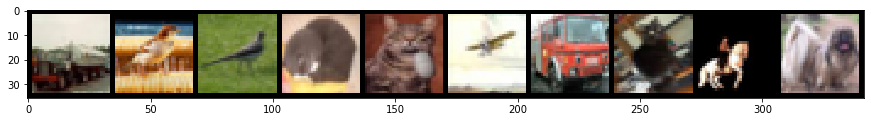

Reconstructed images:


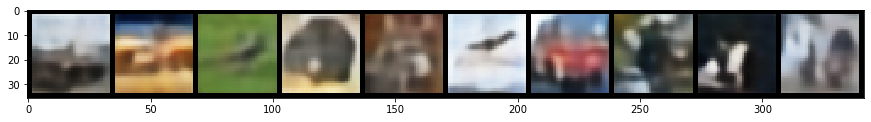

Test loss: 0.025154557079076767


In [13]:
print("Visualising test images...\n")

test_loader = DataLoader(test_set, batch_size=10, shuffle=True)
images, _ = next(iter(test_loader))
print("Original images:")
imgviz(images)
print("Reconstructed images:")
with torch.no_grad():
    preds = ae(images)
    imgviz(preds)

# Test loss
test_loader = DataLoader(test_set, batch_size=len(test_set))
for i, batch in enumerate(test_loader):
    images, _ = batch
    with torch.no_grad():
        preds = ae(images)
        loss = F.mse_loss(preds, images) # calculates the loss
print('Test loss:', loss.item())

## Validate with Kodak image dataset

In [16]:
transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(256),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

kodak_set = torchvision.datasets.ImageFolder(root='../data/Kodak', transform=transform)
kodak_loader = DataLoader(kodak_set, batch_size=24)

In [17]:
def imgviz(images, save_fname=None, nrow=10):
    """
    Displays `images` in a grid, and saves (optionally) output as an image file with
    filename `save_fname`. Format of input must be a Tensor of size 4 (B, C, H, W).
    """
    
    assert len(images.shape) == 4, "Size of input images must be 4."
    
    grid = make_grid(to_img(images), nrow=nrow)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(grid, (1,2,0)))
    
    # If save_fname is given and is a string, save image to local directory
    if type(save_fname) == str:
        if not os.path.exists('./saved_imgs'):
            os.mkdir('./saved_imgs')
        plt.imsave('./saved_imgs/' + save_fname, np.transpose(grid, (1,2,0)).numpy())
    
    # Show image
    plt.show()

Original Kodak images:


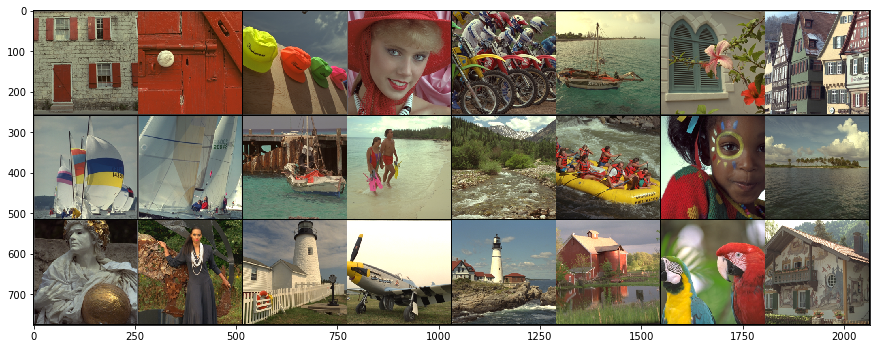

Reconstructed Kodak images:


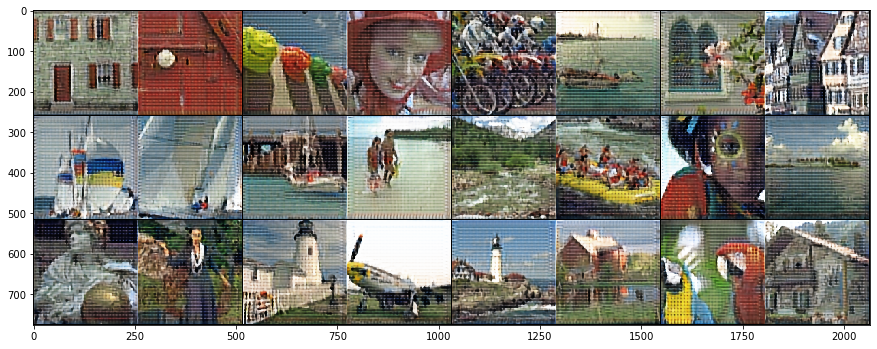

Kodak MSE loss: 0.0494433157145977


In [18]:
# Validate with Kodak
kodak, _ = next(iter(kodak_loader))
print("Original Kodak images:")
imgviz(kodak, save_fname='kodak_imgs.png', nrow=8)
print("Reconstructed Kodak images:")
with torch.no_grad():
    kodak_preds = ae(kodak)
    imgviz(kodak_preds, save_fname='reconstruced_kodak_imgs.png', nrow=8)
    kodak_loss = F.mse_loss(kodak_preds, kodak)
    print('Kodak MSE loss:', kodak_loss.item())

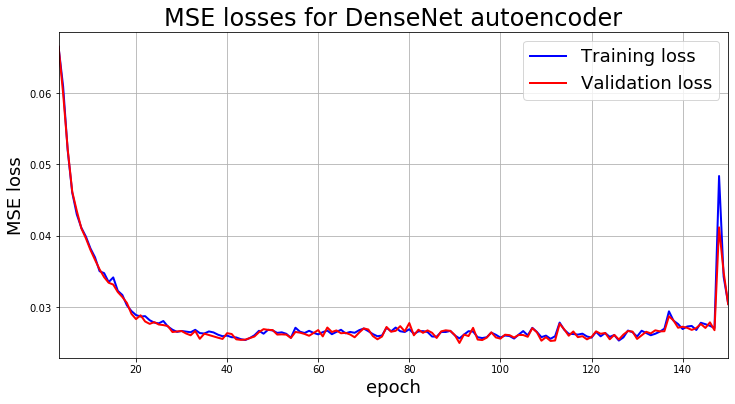

In [20]:
## Visualise losses in graph
train_losses = np.array([m.run.data[i]['train loss'] for i in range(2, len(m.run.data))])
val_losses = np.array([m.run.data[i]['validation loss'] for i in range(2, len(m.run.data))])
epochs = np.array(list(range(3, 151)))

figure = plt.figure(figsize=(12,6))
plt.plot(epochs, train_losses, 'b-', lw=2, label='Training loss')
plt.plot(epochs, val_losses, 'r-', lw=2, label='Validation loss')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('MSE loss', fontsize=18)
plt.title('MSE losses for DenseNet autoencoder', fontsize=24)
plt.xlim([3,150])
plt.legend(fontsize=18)
plt.grid('on')
plt.savefig('./losses')
plt.show()